In [51]:
# SPA vs COIN_FF vs COIN_FF_RL (imitation of COIN_FF)

import math
import random
from dataclasses import dataclass

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
import networkx as nx

import heapq
from collections import defaultdict
from typing import Dict, Tuple, List, Set, Optional

## 1. Load shapefile and build TrafficNetwork

In [2]:
# Path to your shapefile
path = "../trimmed_manhattan_shape/trimmed_manhattan.shp"
gdf = gpd.read_file(path)
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

# If CRS is geographic (lat/lon), reproject to EPSG:2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
print("Reprojected CRS: ", gdf.crs)

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']
Reprojected CRS:  EPSG:2263


## 2. Core types

In [3]:
Node = Tuple[float, float]     # (x, y)
EdgeId = Tuple[Node, Node]     # directed edge
EdgeFlows = Dict[EdgeId, float]


@dataclass
class Edge:
    start: Node
    end: Node
    length_m: float       # meters
    v_free: float         # free-flow speed (m/s)
    capacity: float       # max cars that fit on this segment
    alpha: float = 0.15   # BPR parameters
    beta: float = 4.0

    @property
    def free_time(self) -> float:
        """Free-flow travel time (seconds)."""
        return self.length_m / self.v_free

    def travel_time(self, flow: float) -> float:
        """BPR-style congestion travel time (seconds)."""
        x = flow / self.capacity if self.capacity > 0 else 0.0
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


Graph = Dict[Node, List[EdgeId]]


@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]


def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    """Rounding keeps nodes consistent instead of tiny float differences."""
    return round(x, ndigits), round(y, ndigits)


## 3. Stochastic edge parameters

### Constants

In [57]:
# --- Capacity tuning constants (put near top of file) ---
# Default lanes by OSM 'highway' tag (very rough)
HIGHWAY_DEFAULT_LANES = {
    "motorway": 6,
    "trunk": 5,
    "primary": 5,
    "secondary": 4,
    "tertiary": 2,
    "residential": 2,
    "service": 2,
}

REF_SPEED = 13.89           # m/s ≈ 50 km/h
SPEED_CAPACITY_GAMMA = 0.2  # how strongly speed affects capacity

# Put these near the top of the file, next to your other globals
CAPACITY_SCALE = 20.0    # global multiplier for capacities
MIN_CAPACITY   = 500.0   # minimum cars per directed edge (model units)



In [61]:
def sample_car_length() -> float:
    # lognormal with median around 4.5m
    mu = math.log(4.5)
    sigma = 0.15
    length = random.lognormvariate(mu, sigma)
    return max(length, 3.5)  # clamp to > 3.5m


def sample_gap() -> float:
    # lognormal with median around 1.5m
    mu = math.log(1.5)
    sigma = 0.25
    gap = random.lognormvariate(mu, sigma)
    return max(gap, 0.5)


def sample_spacing() -> float:
    """Space per vehicle = car length + gap."""
    return sample_car_length() + sample_gap()


def sample_free_speed_time_based() -> float:
    """
    Sample free-flow speed via a lognormal model on time-per-meter.
    This gives a fatter tail toward low speeds.
    """
    median_s_per_m = 0.09  # ~40 km/h
    mu = math.log(median_s_per_m)
    sigma = 0.3  # spread; larger => more slow edges
    s_per_m = random.lognormvariate(mu, sigma)  # seconds per meter
    v_free = 1.0 / s_per_m  # m/s

    # clamp speeds to a plausible urban range ~ 18–90 km/h
    v_free = max(min(v_free, 25.0), 5.0)
    return v_free

def network_from_streets_gdf(streets_gdf: gpd.GeoDataFrame) -> TrafficNetwork:
    """
    Build a directed TrafficNetwork from a GeoDataFrame of street segments.

    Capacity is based on:
        - geometric length / spacing  (cars that fit on the segment)
        - free-flow speed (faster links get slightly higher capacity)
        - a global CAPACITY_SCALE (so capacities are large vs. agent flows)
        - a global MIN_CAPACITY (so no edge is absurdly small)

    The result is that, for your Manhattan test with ~100 agents,
    typical v/c ratios stay in a reasonable range instead of exploding.
    """
    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    for _, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        # Handle MultiLineString and LineString
        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            for (x1, y1), (x2, y2) in zip(coords[:-1], coords[1:]):
                u = make_node(x1, y1)
                v = make_node(x2, y2)

                seg = LineString([(x1, y1), (x2, y2)])
                length_m = seg.length

                # --- stochastic spacing & free-flow speed ---
                spacing = sample_spacing()                # [m / car]
                v_free  = sample_free_speed_time_based()  # [m / s]

                # cars that physically fit on this small segment
                base_cars = max(length_m / spacing, 1.0)

                # modest boost for faster links (e.g. avenues vs local streets)
                v_ref = 15.0  # m/s ≈ 54 km/h
                speed_factor = max(v_free / v_ref, 0.5)   # avoid tiny factors

                # final capacity for this directed edge
                capacity = base_cars * speed_factor * CAPACITY_SCALE
                capacity = max(capacity, MIN_CAPACITY)

                # directed u -> v
                e1 = (u, v)
                if e1 not in edges:
                    edges[e1] = Edge(
                        start=u,
                        end=v,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[u].append(e1)

                # bidirectional by default
                e2 = (v, u)
                if e2 not in edges:
                    edges[e2] = Edge(
                        start=v,
                        end=u,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[v].append(e2)

    return TrafficNetwork(graph=dict(graph), edges=edges)


# Build network
manhattan_network = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")


# nodes: 37086
# edges: 81228


## 4. NetworkX conversion (for sanity plot)

# NX nodes: 37086 # NX edges: 81228


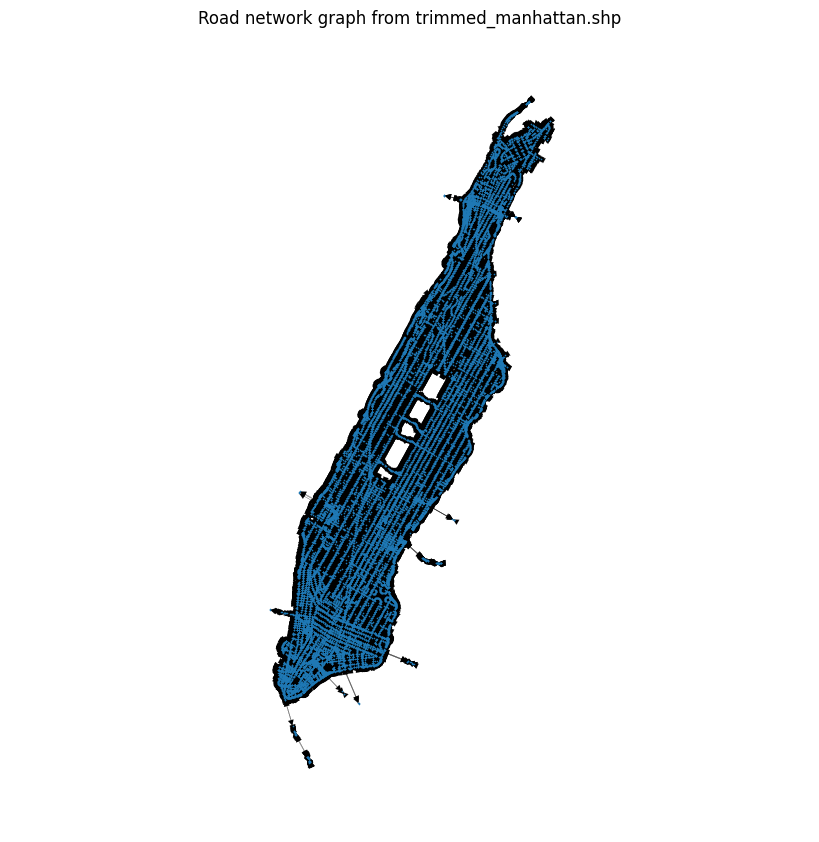

In [62]:
def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()
    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])
    for e_id, edge in network.edges.items():
        G.add_edge(edge.start, edge.end,
                   free_time=edge.free_time,
                   capacity=edge.capacity)
    return G


G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

## 5. Agents + OD selection

In [63]:
@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None


def sample_agents_random(network: TrafficNetwork, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def sample_agents_north_south(
    network: TrafficNetwork,
    num_agents: int,
    band_split: float = 0.5,
) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]
    assert north_nodes and south_nodes, "North/south bands empty – check CRS/band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def pick_north_south_pair(network: TrafficNetwork) -> Tuple[Node, Node]:
    """Pick a single north–south OD pair to keep SPA / COIN_FF comparable."""
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)

    # north = top 20%, south = bottom 20%
    north_nodes = [n for n in nodes if n[1] >= y_min + 0.8 * (y_max - y_min)]
    south_nodes = [n for n in nodes if n[1] <= y_min + 0.2 * (y_max - y_min)]

    o = random.choice(north_nodes)
    d = random.choice(south_nodes)
    return o, d


def sample_agents_fixed(
    network: TrafficNetwork,
    num_agents: int,
    origin: Node,
    destination: Node
) -> List[Agent]:
    return [Agent(origin=origin, destination=destination) for _ in range(num_agents)]


## 6. Dijkstra (SPA) and marginal-cost Dijkstra (COIN_FF)

In [64]:
def dijkstra(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """Standard Dijkstra where cost = current travel time t(flow)."""
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flows[edge_id])
            nd = d_u + w
            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []  # no path found

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edge_marginal_cost(edge: Edge, flow_before: float) -> float:
    """
    Given that 'flow_before' cars already use this edge,
    what is the marginal increase in total system travel time G
    if we send one more car along it?
    """
    f1 = flow_before
    f2 = flow_before + 1
    t1 = edge.travel_time(f1)
    t2 = edge.travel_time(f2)
    G1 = f1 * t1
    G2 = f2 * t2
    return G2 - G1


def dijkstra_coin_ff_marginal(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """
    Ford–Fulkerson style path search:
    shortest path where edge weight is the *marginal increase in G*
    if we send one additional car along that edge.
    Edges with flow >= capacity are treated as 'blocked'.
    """
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        cost_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end

            # Respect capacity (no residual capacity => no edge)
            if edge_flows[edge_id] >= edge.capacity:
                continue

            f_before = edge_flows[edge_id]
            marginal = edge_marginal_cost(edge, f_before)
            new_cost = cost_u + marginal

            if v not in dist or new_cost < dist[v]:
                dist[v] = new_cost
                prev[v] = u
                heapq.heappush(pq, (new_cost, v))

    if target not in dist:
        return []  # no path

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))



## 7. Routing: SPA and COIN_FF

In [65]:
def spa_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """Selfish Path Assignment (SPA): each agent uses shortest travel-time path."""
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra(network, agent.origin, agent.destination, edge_flows)
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0  # 1 vehicle per agent
    return agents, edge_flows


def coin_ff_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """
    Ford–Fulkerson–style COIN:
    - For each agent, find a path that minimizes the marginal increase in G
      (using dijkstra_coin_ff_marginal).
    - Push 1 unit of flow along that path.
    """
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra_coin_ff_marginal(
            network,
            agent.origin,
            agent.destination,
            edge_flows
        )
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0
    return agents, edge_flows


## 8. World utility & OD used for fixed experiments

In [66]:
def total_system_travel_time(network: TrafficNetwork, edge_flows: EdgeFlows) -> float:
    total = 0.0
    for e_id, flow in edge_flows.items():
        edge = network.edges[e_id]
        total += flow * edge.travel_time(flow)
    return total


# Fixed OD pair (global, to keep things simple and consistent)
origin, destination = pick_north_south_pair(manhattan_network)
zero_flows = defaultdict(float)
shortest_path = dijkstra(manhattan_network, origin, destination, zero_flows)
shortest_edges = set(edges_from_path(shortest_path))

print("Origin:", origin)
print("Destination:", destination)
print("Shortest path length (edges):", len(shortest_path))


def dist_to_dest(node: Node, dest: Node) -> float:
    return math.dist(node, dest)

Origin: (1005283.142, 255884.729)
Destination: (983423.642, 196583.471)
Shortest path length (edges): 904


## 9. COIN_FF → Expert Dataset for Imitation Learning

In [72]:
# ==== RL / imitation constants ====

TIME_SCALE = 1000.0    # divide edge times by this when using them as rewards
TERMINAL_BONUS = 5.0   # small positive bonus for steps that land exactly on dest

def get_neighbors(network: TrafficNetwork, node: Node) -> List[Node]:
    return [network.edges[e_id].end for e_id in network.graph.get(node, [])]


def choose_action_eps_greedy(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    state_node: Node,
    dest_node: Node,
    epsilon: float
) -> Node:
    neighbors = get_neighbors(network, state_node)
    if not neighbors:
        return state_node  # dead end, stay put (loop will break)

    # exploration
    if random.random() < epsilon:
        return random.choice(neighbors)

    # exploitation: pick neighbor with highest Q
    best_q = None
    best_actions = []
    for a in neighbors:
        key = (state_node, dest_node, a)
        q = Q.get(key, 0.0)
        if best_q is None or q > best_q:
            best_q = q
            best_actions = [a]
        elif q == best_q:
            best_actions.append(a)
    return random.choice(best_actions)


def build_coin_ff_expert_dataset(
    network: TrafficNetwork,
    num_agents: int = 200,
    od_mode: str = "fixed"
):
    """
    Run COIN_FF once and record expert transitions.

    Returns
    -------
    expert_steps : list of (s, d, a, edge_id)
        s : state node
        d : destination node
        a : action (next node)
        edge_id : (s, a) so we can read flow/cost later
    agents_coin_ff : list[Agent]
    flows_coin_ff  : EdgeFlows
    """
    # Sample agents according to od_mode
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    # Route with COIN_FF
    agents_coin_ff, flows_coin_ff = coin_ff_route_all(network, agents)

    expert_steps = []  # list of (s, d, a, edge_id)
    for agent in agents_coin_ff:
        # keep only successful trajectories
        if not agent.path or agent.path[-1] != agent.destination:
            continue
        d = agent.destination
        for (s, a) in edges_from_path(agent.path):
            edge_id = (s, a)
            expert_steps.append((s, d, a, edge_id))

    print(
        f"Collected {len(expert_steps)} expert (s,d,a,edge_id) steps "
        f"from {len(agents_coin_ff)} COIN_FF agents."
    )
    return expert_steps, agents_coin_ff, flows_coin_ff


# ==== scaling constants (place these at the top of your RL section) ====
TIME_SCALE = 1000.0      # divides travel times
TERMINAL_BONUS = 5.0     # small reward bump when transition lands on destination


def train_q_from_coin_ff_expert(
    expert_steps,
    flows_coin_ff: EdgeFlows,
    network: TrafficNetwork,
    alpha_bc: float = 0.5
) -> Dict[Tuple[Node, Node, Node], float]:
    """
    Cost-aware behavior cloning:

    For each expert step (s,d,a,edge_id), compute the scaled negative
    congested travel time of that edge under COIN_FF flows:

        reward = -(t_edge / TIME_SCALE)

    Plus an optional TERMINAL_BONUS if a == d.

    Then update:
        Q(s,d,a) <- Q(s,d,a) + alpha_bc * (reward - Q(s,d,a))
    """
    Q: Dict[Tuple[Node, Node, Node], float] = {}

    for (s, d, a, edge_id) in expert_steps:
        edge = network.edges[edge_id]
        flow = flows_coin_ff[edge_id]

        # --- scaled cost ---
        t_edge = edge.travel_time(flow)       # seconds
        t_scaled = t_edge / TIME_SCALE        # shrink magnitude
        reward = -t_scaled                    # negative cost

        # --- terminal bonus if this step ends the trip ---
        if a == d:
            reward += TERMINAL_BONUS

        # --- Q-update ---
        key = (s, d, a)
        old_q = Q.get(key, 0.0)
        Q[key] = old_q + alpha_bc * (reward - old_q)

    print(
        f"Trained Q on {len(expert_steps)} expert steps "
        f"(unique state–action pairs: {len(Q)})."
    )
    return Q


import heapq
from collections import defaultdict
from typing import Dict, Tuple, List, Set, Optional

def route_with_trained_Q(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int,
    od_mode: str = "fixed",
    max_steps_per_agent: int = 1500,
    fallback_mode: str = "free_time",   # "random", "free_time", or "spa"
    spa_mix_prob: float = 0.3,          # when fallback_mode=="spa": prob of using SPA on each step
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Evaluate a trained Q-table by routing agents and computing total system travel time G.

    Policy per step:
      * If fallback_mode=="spa" and with prob spa_mix_prob, take a SPA step
        (precomputed shortest-path-to-dest) if available.
      * Else, if Q has info at (s,d,·), take greedy argmax_a Q(s,d,a).
      * Else, fall back according to fallback_mode:
          - "random": random neighbor
          - "free_time": neighbor with smallest free-flow time
          - "spa": SPA step if available, else free_time
    """

    # ---------- precompute SPA next-step table if needed ----------
    spa_next: Dict[Node, Node] = {}

    if fallback_mode == "spa" and od_mode == "fixed":
        # we assume global "destination" is defined and matches agents' dest
        dest_node = destination

        # Build reverse graph: for each edge u->v, add v->u in reverse_graph
        reverse_graph: Dict[Node, List[Tuple[Node, float]]] = defaultdict(list)
        for (u, v), edge in network.edges.items():
            reverse_graph[v].append((u, edge.free_time))

        # Dijkstra on reverse graph from dest_node
        dist: Dict[Node, float] = {dest_node: 0.0}
        prev: Dict[Node, Node] = {}
        pq: List[Tuple[float, Node]] = [(0.0, dest_node)]

        while pq:
            d_cur, u = heapq.heappop(pq)
            if d_cur > dist.get(u, float('inf')):
                continue
            for (v, w) in reverse_graph.get(u, []):
                nd = d_cur + w
                if nd < dist.get(v, float('inf')):
                    dist[v] = nd
                    prev[v] = u
                    heapq.heappush(pq, (nd, v))

        # From this tree, for any node s≠dest, spa_next[s] is the neighbor on
        # a shortest path s -> dest.
        for node, parent in prev.items():
            # parent is one step closer to dest on reverse tree, so going
            # node -> parent moves us toward dest on the original graph.
            spa_next[node] = parent

        def spa_next_step(node_s: Node, node_d: Node) -> Optional[Node]:
            if node_s == node_d:
                return None
            return spa_next.get(node_s, None)
    else:
        # no SPA table needed
        def spa_next_step(node_s: Node, node_d: Node) -> Optional[Node]:
            return None

    # ---------- main routing ----------
    edge_flows: EdgeFlows = defaultdict(float)

    # sample new agents
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode == "north_south":
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0
        visited: Set[Node] = set()

        while s != d and steps < max_steps_per_agent:
            neighbors = get_neighbors(network, s)
            if not neighbors:
                break

            visited.add(s)

            # ----- (A) SPA mixing step (if enabled) -----
            use_spa_step = (
                fallback_mode == "spa" and
                random.random() < spa_mix_prob
            )

            if use_spa_step:
                a_spa = spa_next_step(s, d)
                if a_spa is not None and a_spa in neighbors:
                    a = a_spa
                else:
                    use_spa_step = False

            if not use_spa_step:
                # ----- (B) Greedy Q-step if we have info -----
                best_q = None
                best_actions: List[Node] = []
                for a_candidate in neighbors:
                    key = (s, d, a_candidate)
                    q_val = Q.get(key, None)
                    if q_val is None:
                        continue
                    if best_q is None or q_val > best_q:
                        best_q = q_val
                        best_actions = [a_candidate]
                    elif q_val == best_q:
                        best_actions.append(a_candidate)

                if best_actions:
                    a = random.choice(best_actions)
                else:
                    # ----- (C) Fallback if Q has no info -----
                    if fallback_mode == "random":
                        a = random.choice(neighbors)

                    elif fallback_mode == "free_time":
                        unvisited = [nxt for nxt in neighbors if nxt not in visited]
                        candidates = unvisited if unvisited else neighbors
                        a = min(
                            candidates,
                            key=lambda nxt: network.edges[(s, nxt)].free_time
                        )

                    elif fallback_mode == "spa":
                        a_spa = spa_next_step(s, d)
                        if a_spa is not None and a_spa in neighbors:
                            a = a_spa
                        else:
                            unvisited = [nxt for nxt in neighbors if nxt not in visited]
                            candidates = unvisited if unvisited else neighbors
                            a = min(
                                candidates,
                                key=lambda nxt: network.edges[(s, nxt)].free_time
                            )
                    else:
                        a = random.choice(neighbors)

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            edge_flows[edge_id] += 1.0
            s = a
            path.append(s)
            steps += 1

        agent.path = path

    G = total_system_travel_time(network, edge_flows)
    return agents, edge_flows, G

## 10. Experiment wrappers: SPA & COIN_FF & COIN_FF_RL(BC)

In [68]:
def run_spa_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "north_south"
) -> Tuple[List[Agent], EdgeFlows, float]:
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    elif od_mode == "fixed":
        agents = sample_agents_fixed(network, num_agents, origin, destination)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_flows = spa_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_SPA: {G:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_coin_ff_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "fixed"
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Ford–Fulkerson style COIN_FF experiment:
    routes agents using coin_ff_route_all and computes world utility G.
    """
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    agents, edge_flows = coin_ff_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"COIN_FF experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_COIN_FF: {G:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_coin_ff_rl_from_expert_experiment(
    network: TrafficNetwork,
    num_agents_baseline: int = 100,
    num_agents_expert: int = 200,
    num_agents_eval_rl: int = 100,
    od_mode: str = "fixed"
):
    """
    1) SPA baseline
    2) COIN_FF baseline
    3) COIN_FF expert dataset
    4) COIN_FF_RL(BC): Q-policy trained to imitate COIN_FF,
       then evaluated on fresh agents with route_with_trained_Q.
    """
    # --- 1) SPA baseline ---
    agents_spa, flows_spa, G_spa = run_spa_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # --- 2) COIN_FF baseline ---
    agents_coin_ff, flows_coin_ff, G_coin_ff = run_coin_ff_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # --- 3) Expert dataset (can use more agents to enrich dataset) ---
    expert_steps, _, flows_expert = build_coin_ff_expert_dataset(
        network,
        num_agents=num_agents_expert,
        od_mode=od_mode,
    )

    # --- 4) Train imitation Q (cost-aware) and evaluate COIN_FF_RL ---
    Q_rl = train_q_from_coin_ff_expert(
        expert_steps=expert_steps,
        flows_coin_ff=flows_expert,
        network=network,
        alpha_bc=0.5,
    )
    agents_coin_ff_rl, flows_coin_ff_rl, G_coin_ff_rl = route_with_trained_Q(
        network = network,
        Q = Q_rl,
        num_agents=num_agents_eval_rl,
        od_mode=od_mode,
        max_steps_per_agent=1500,
        fallback_mode="spa",
    )

    print("\n=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC, cost-aware) ===")
    print(f"G_SPA          = {G_spa:.2f}")
    print(f"G_COIN_FF      = {G_coin_ff:.2f}")
    print(f"G_COIN_FF_RL   = {G_coin_ff_rl:.2f}")
    print(f"Improvement (COIN_FF vs SPA)      = {(G_spa - G_coin_ff) / G_spa * 100:.2f}%")
    print(f"Improvement (COIN_FF_RL vs SPA)   = {(G_spa - G_coin_ff_rl) / G_spa * 100:.2f}%")

    return (
        agents_spa, flows_spa, G_spa,
        agents_coin_ff, flows_coin_ff, G_coin_ff,
        agents_coin_ff_rl, flows_coin_ff_rl, G_coin_ff_rl,
        Q_rl,
    )

## 11. Metrics & visualisation helpers

In [69]:
def fraction_reached(agents: List[Agent], dest: Node) -> float:
    reached = sum(1 for a in agents if a.path and a.path[-1] == dest)
    return reached / len(agents)


def compute_agent_travel_times(
        network: TrafficNetwork,
        edge_flows: EdgeFlows,
        agents: List[Agent]) -> List[float]:
    times = []
    for agent in agents:
        if not agent.path or len(agent.path) < 2:
            times.append(0.0)
            continue
        total = 0.0
        for u, v in edges_from_path(agent.path):
            edge = network.edges[(u, v)]
            flow = edge_flows[(u, v)]
            total += edge.travel_time(flow)
        times.append(total)
    return times


def routes_to_gdf(agents: List[Agent], crs) -> gpd.GeoDataFrame:
    geoms = []
    for agent in agents:
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    return gpd.GeoDataFrame(geometry=geoms, crs=crs)


def edge_flows_to_gdf(
        edge_flows: EdgeFlows,
        network: TrafficNetwork,
        crs) -> gpd.GeoDataFrame:
    geoms = []
    flows = []
    for (u, v), f in edge_flows.items():
        if f <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows.append(f)
    return gpd.GeoDataFrame({"flow": flows}, geometry=geoms, crs=crs)

def total_distance_from_flows(network: TrafficNetwork, flows: EdgeFlows) -> float:
    """
    Total distance traveled in the network (sum over all agents),
    computed from edge flows.

    Returns
    -------
    distance_m : float
        Total distance in meters.
    """
    dist_m = 0.0
    for edge_id, f in flows.items():
        if f <= 0.0:
            continue
        edge = network.edges[edge_id]
        dist_m += edge.length_m * f
    return dist_m


def print_scenario_metrics(
        name: str,
        network: TrafficNetwork,
        flows: EdgeFlows,
        G: float,
        num_agents: int) -> None:
    """
    Print average travel time and distance per agent,
    plus total distance for a given scenario.
    """
    # G is total system travel time (seconds)
    avg_time_s = G / num_agents
    avg_time_min = avg_time_s / 60.0

    total_dist_m = total_distance_from_flows(network, flows)
    total_dist_km = total_dist_m / 1000.0
    avg_dist_m = total_dist_m / num_agents
    avg_dist_km = avg_dist_m / 1000.0

    print(f"\n[{name}] metrics:")
    print(f"  Average travel time per agent: {avg_time_s:8.2f} s  ({avg_time_min:6.2f} min)")
    print(f"  Total distance traveled:       {total_dist_km:8.2f} km")
    print(f"  Average distance per agent:    {avg_dist_km:8.2f} km")


def plot_routes_spa_vs_coin_ff(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
):
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # SPA routes
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF routes
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF routes (G = {G_coin_ff:.1f})")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()


def plot_routes_spa_vs_coin_ff_rl(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
):
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_coin_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # SPA routes
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF_RL routes
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_coin_ff_rl.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF_RL routes (G = {G_coin_ff_rl:.1f})")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()


def plot_routes_three_way(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
):
    """
    Single figure with three panels:
    [SPA | COIN_FF | COIN_FF_RL]
    """
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)
    routes_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 3, figsize=(21, 8))

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF routes (G = {G_coin_ff:.1f})")
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.3, color="lightgray")
    routes_ff_rl.plot(ax=axes[2], linewidth=1.2, alpha=0.9)
    axes[2].set_title(f"COIN_FF_RL routes (G = {G_coin_ff_rl:.1f})")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

## 11A. Heatmp helper functions

In [70]:
def plot_heatmaps_spa_vs_coin_ff(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff: EdgeFlows,
):
    """
    Two-panel heatmap of edge flows:
    left  = SPA flows
    right = COIN_FF flows
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,  network, crs=gdf.crs)
    ff_gdf   = edge_flows_to_gdf(flows_coin_ff, network, crs=gdf.crs)

    if spa_gdf.empty or ff_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(spa_gdf["flow"].max(), ff_gdf["flow"].max())

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # SPA heatmap
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="viridis",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF heatmap
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="viridis",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF edge flows")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

def plot_heatmaps_spa_vs_coin_ff_rl(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff_rl: EdgeFlows,
):
    """
    Two-panel heatmap:
    left  = SPA flows
    right = COIN_FF_RL flows
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,  network, crs=gdf.crs)
    rl_gdf   = edge_flows_to_gdf(flows_coin_ff_rl, network, crs=gdf.crs)

    if spa_gdf.empty or rl_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(spa_gdf["flow"].max(), rl_gdf["flow"].max())

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # SPA heatmap
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="inferno",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF_RL heatmap
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="inferno",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF_RL edge flows")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

def plot_heatmaps_three_way(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff: EdgeFlows,
    flows_coin_ff_rl: EdgeFlows,
):
    """
    Three-panel heatmap:
    [ SPA | COIN_FF | COIN_FF_RL ]
    All share the same color scale so intensities are comparable.
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,       network, crs=gdf.crs)
    ff_gdf   = edge_flows_to_gdf(flows_coin_ff,   network, crs=gdf.crs)
    rl_gdf   = edge_flows_to_gdf(flows_coin_ff_rl, network, crs=gdf.crs)

    if spa_gdf.empty or ff_gdf.empty or rl_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(
        spa_gdf["flow"].max(),
        ff_gdf["flow"].max(),
        rl_gdf["flow"].max(),
    )

    fig, axes = plt.subplots(1, 3, figsize=(22, 8))

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF edge flows")
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[2],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[2].set_title("COIN_FF_RL edge flows")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

## 12. Run main experiment (SPA vs COIN_FF vs COIN_FF_RL)

SPA experiment with 10 agents (fixed O/D)
Total system travel time G_SPA: 58545.17
Used edges: 903 / 81228
COIN_FF experiment with 10 agents (fixed O/D)
Total system travel time G_COIN_FF: 58545.17
Used edges: 903 / 81228
Collected 9030 expert (s,d,a,edge_id) steps from 10 COIN_FF agents.
Trained Q on 9030 expert steps (unique state–action pairs: 903).

=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC, cost-aware) ===
G_SPA          = 58545.17
G_COIN_FF      = 58545.17
G_COIN_FF_RL   = 58545.17
Improvement (COIN_FF vs SPA)      = 0.00%
Improvement (COIN_FF_RL vs SPA)   = 0.00%

SPA fraction reaching dest: 1.0
COIN_FF fraction reaching dest: 1.0
COIN_FF_RL fraction reaching dest: 1.0

[SPA] metrics:
  Average travel time per agent:  5854.52 s  ( 97.58 min)
  Total distance traveled:         670.17 km
  Average distance per agent:       67.02 km

[COIN_FF] metrics:
  Average travel time per agent:  5854.52 s  ( 97.58 min)
  Total distance traveled:         670.17 km
  Average distance per ag

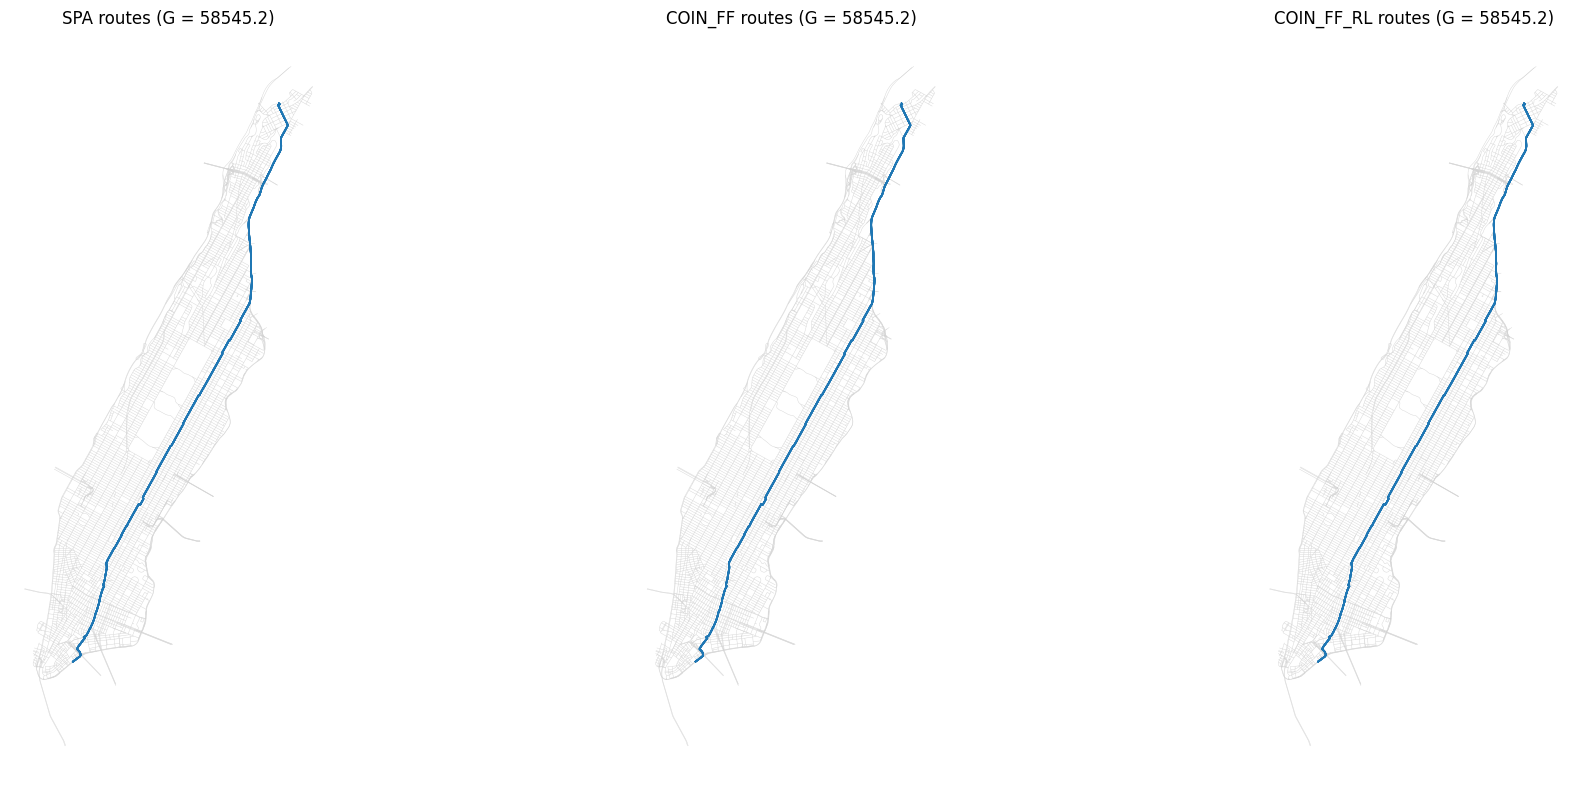

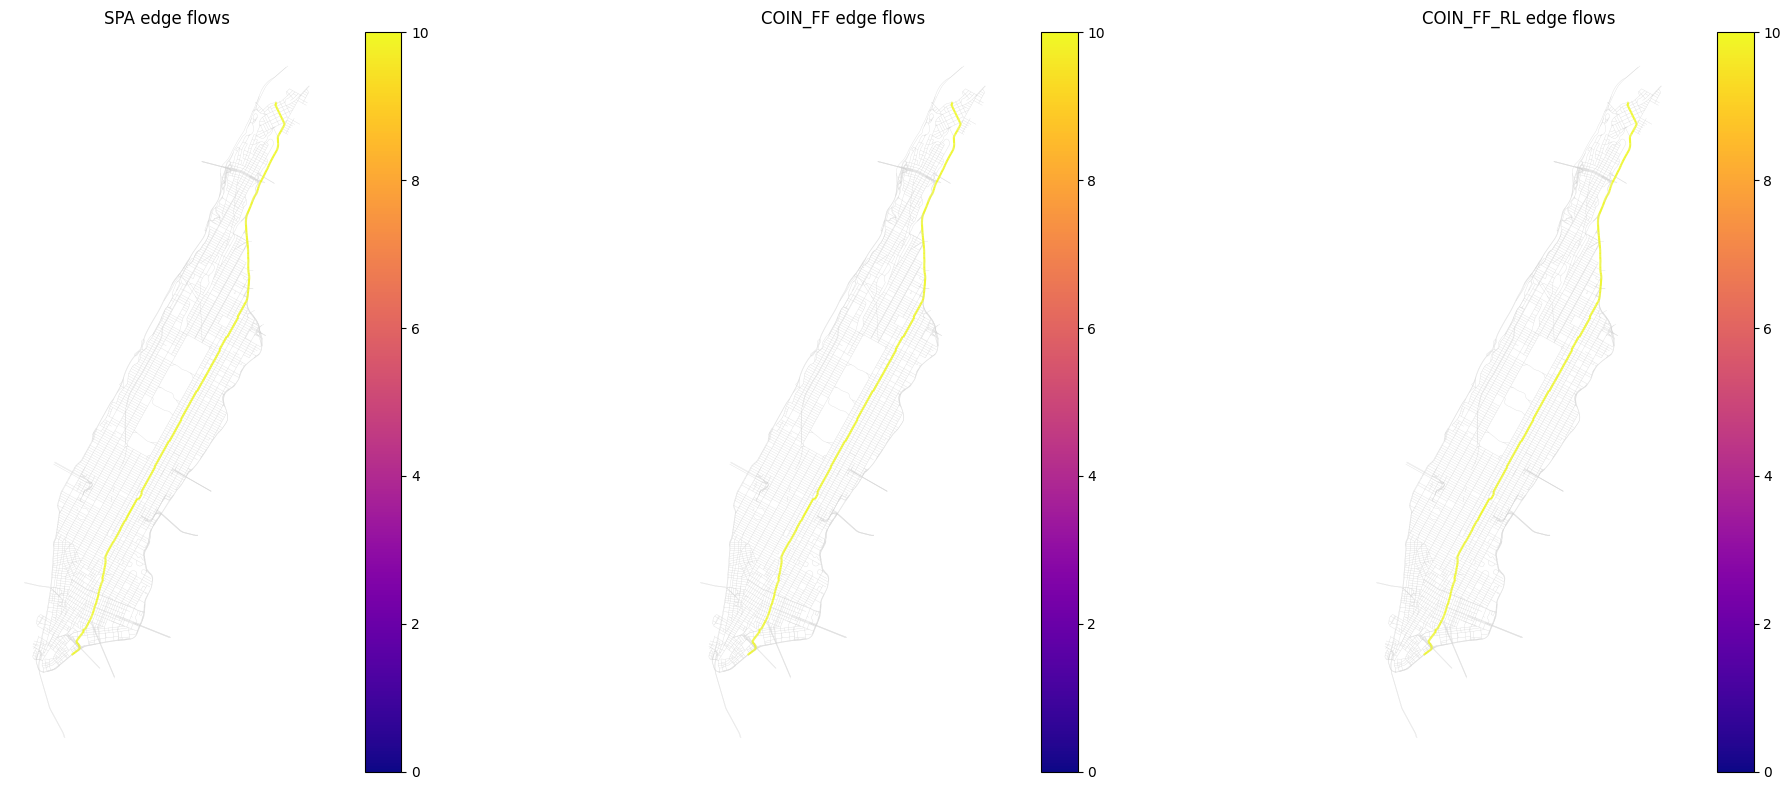

In [73]:
random.seed(42)

# Number of agents:
num_agents = 10

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_rl_from_expert_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents,
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
)

# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa,      G_spa,
    agents_coin_ff,  G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)

SPA experiment with 100 agents (fixed O/D)
Total system travel time G_SPA: 585556.27
Used edges: 903 / 81228
COIN_FF experiment with 100 agents (fixed O/D)
Total system travel time G_COIN_FF: 585556.27
Used edges: 903 / 81228
Collected 90300 expert (s,d,a,edge_id) steps from 100 COIN_FF agents.
Trained Q on 90300 expert steps (unique state–action pairs: 903).

=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC, cost-aware) ===
G_SPA          = 585556.27
G_COIN_FF      = 585556.27
G_COIN_FF_RL   = 585556.27
Improvement (COIN_FF vs SPA)      = 0.00%
Improvement (COIN_FF_RL vs SPA)   = 0.00%

SPA fraction reaching dest: 1.0
COIN_FF fraction reaching dest: 1.0
COIN_FF_RL fraction reaching dest: 1.0

[SPA] metrics:
  Average travel time per agent:  5855.56 s  ( 97.59 min)
  Total distance traveled:        6701.73 km
  Average distance per agent:       67.02 km

[COIN_FF] metrics:
  Average travel time per agent:  5855.56 s  ( 97.59 min)
  Total distance traveled:        6701.73 km
  Average dista

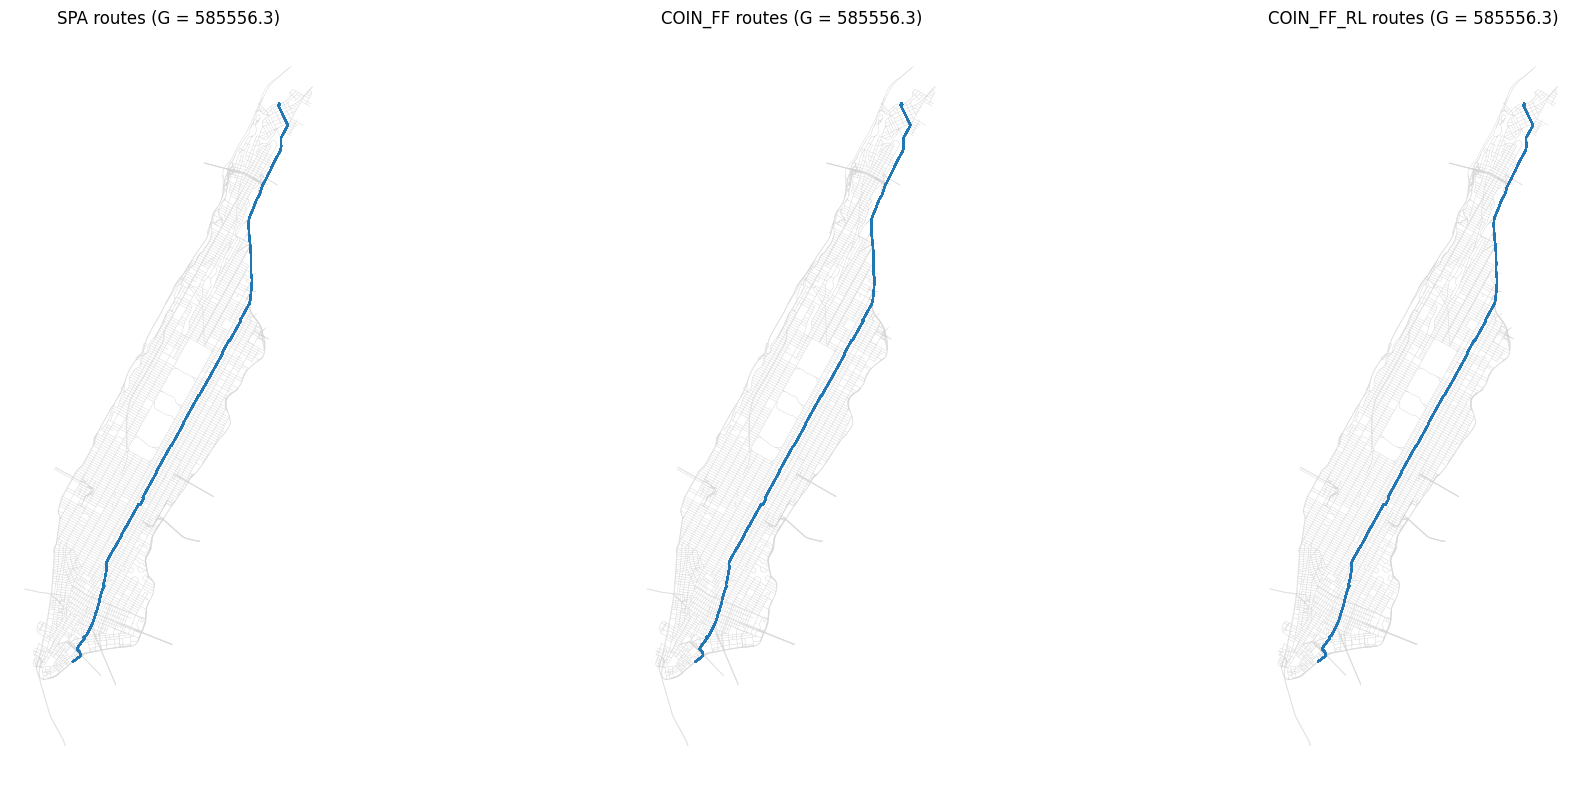

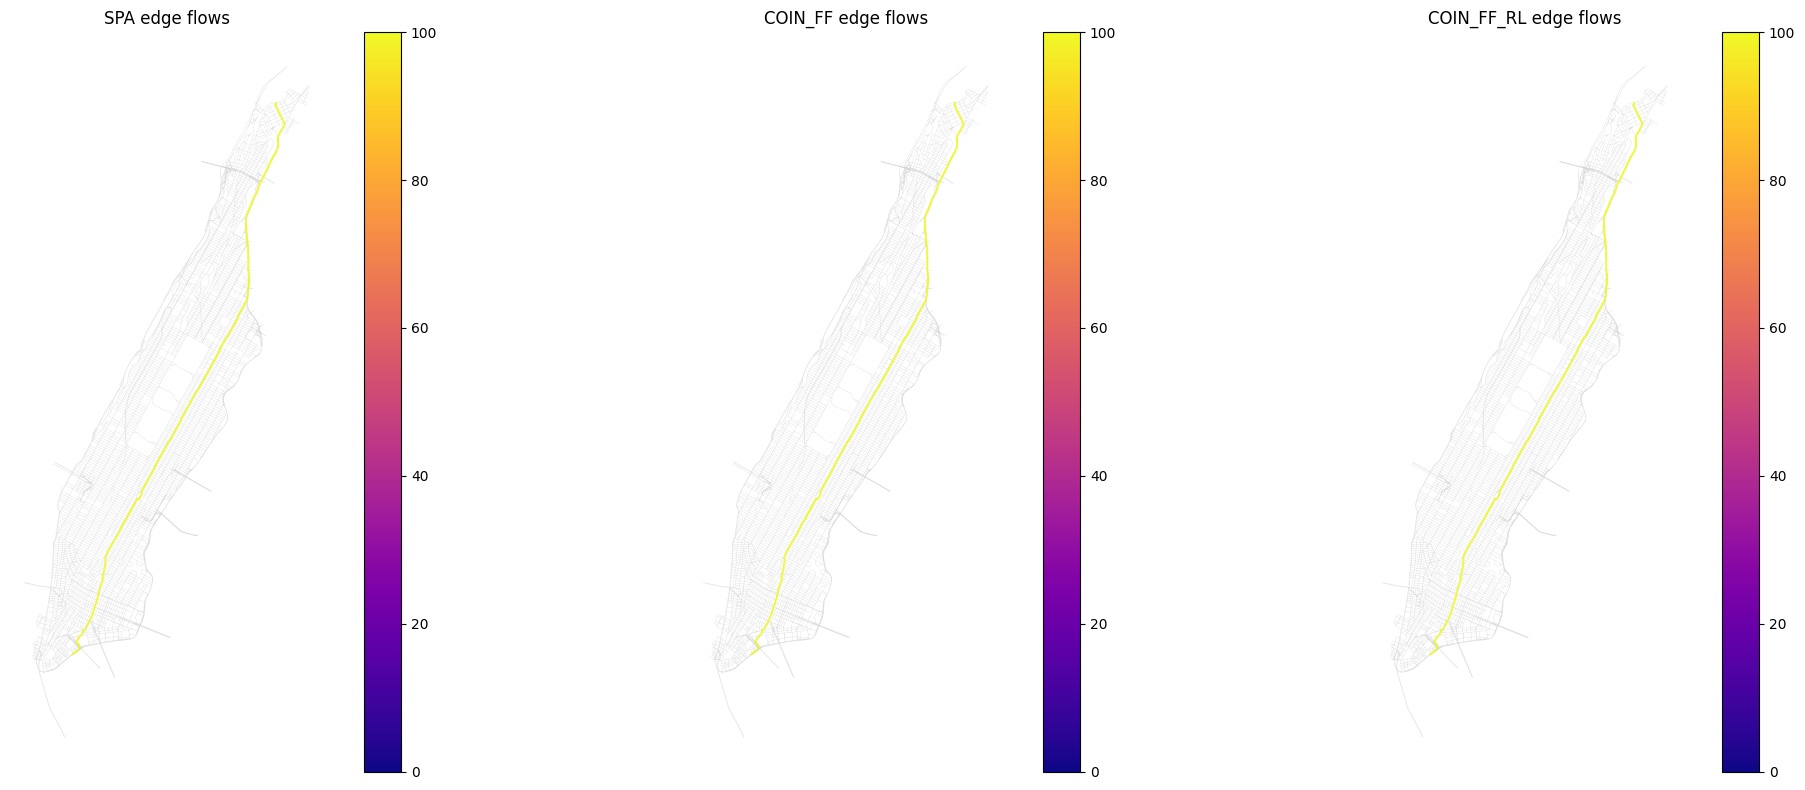

In [74]:
random.seed(42)

# Number of agents:
num_agents = 100

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_rl_from_expert_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents,
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
)

# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa,      G_spa,
    agents_coin_ff,  G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)

SPA experiment with 500 agents (fixed O/D)
Total system travel time G_SPA: 3062126.65
Used edges: 2374 / 81228
COIN_FF experiment with 500 agents (fixed O/D)
Total system travel time G_COIN_FF: 3010967.94
Used edges: 3217 / 81228
Collected 477355 expert (s,d,a,edge_id) steps from 500 COIN_FF agents.
Trained Q on 477355 expert steps (unique state–action pairs: 3217).

=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC, cost-aware) ===
G_SPA          = 3062126.65
G_COIN_FF      = 3010967.94
G_COIN_FF_RL   = 3163416.68
Improvement (COIN_FF vs SPA)      = 1.67%
Improvement (COIN_FF_RL vs SPA)   = -3.31%

SPA fraction reaching dest: 1.0
COIN_FF fraction reaching dest: 1.0
COIN_FF_RL fraction reaching dest: 1.0

[SPA] metrics:
  Average travel time per agent:  6124.25 s  (102.07 min)
  Total distance traveled:       33991.63 km
  Average distance per agent:       67.98 km

[COIN_FF] metrics:
  Average travel time per agent:  6021.94 s  (100.37 min)
  Total distance traveled:       34534.29 km
  Av

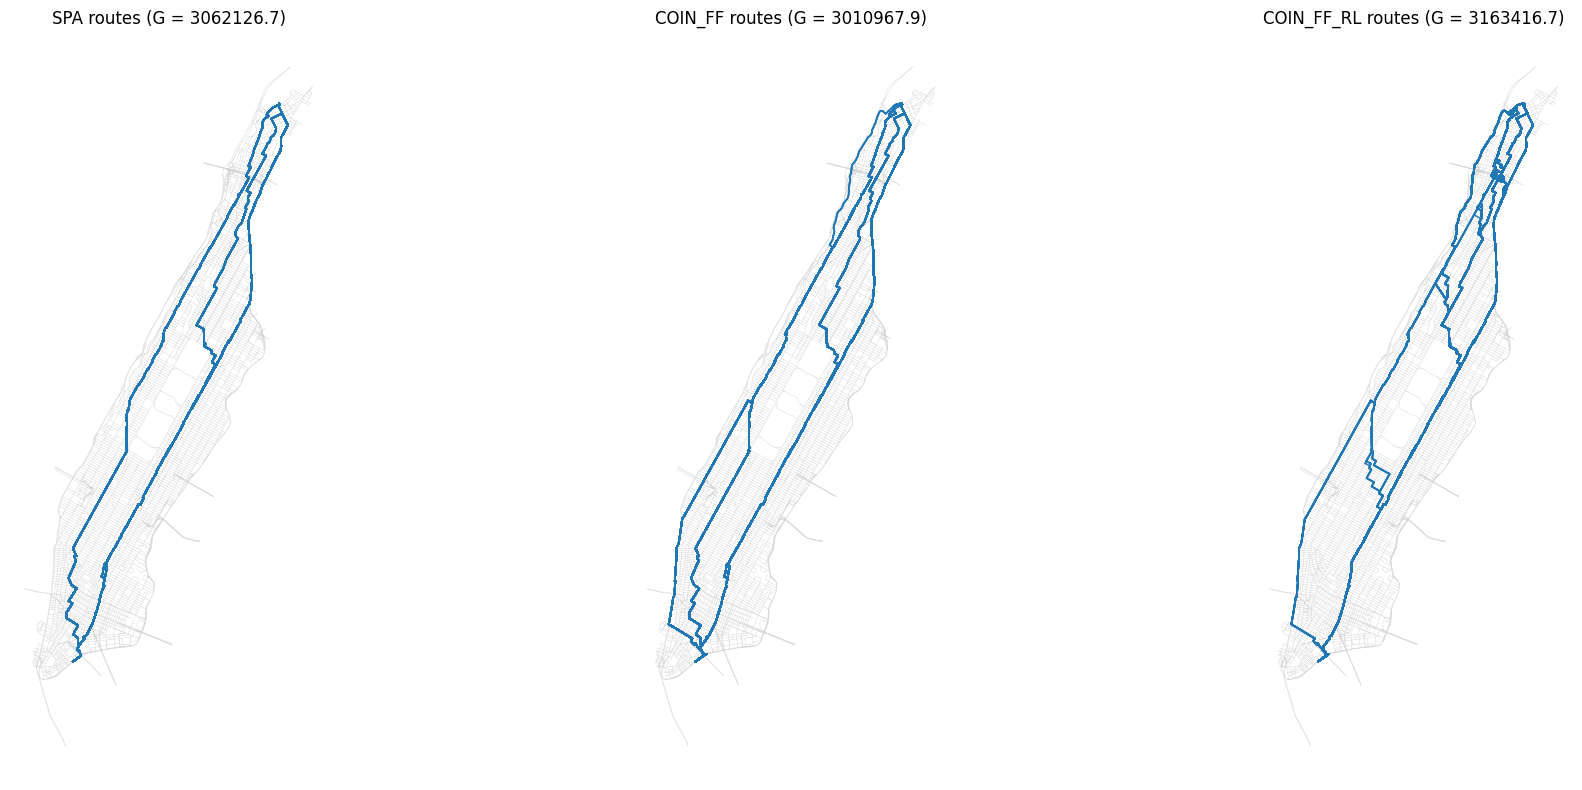

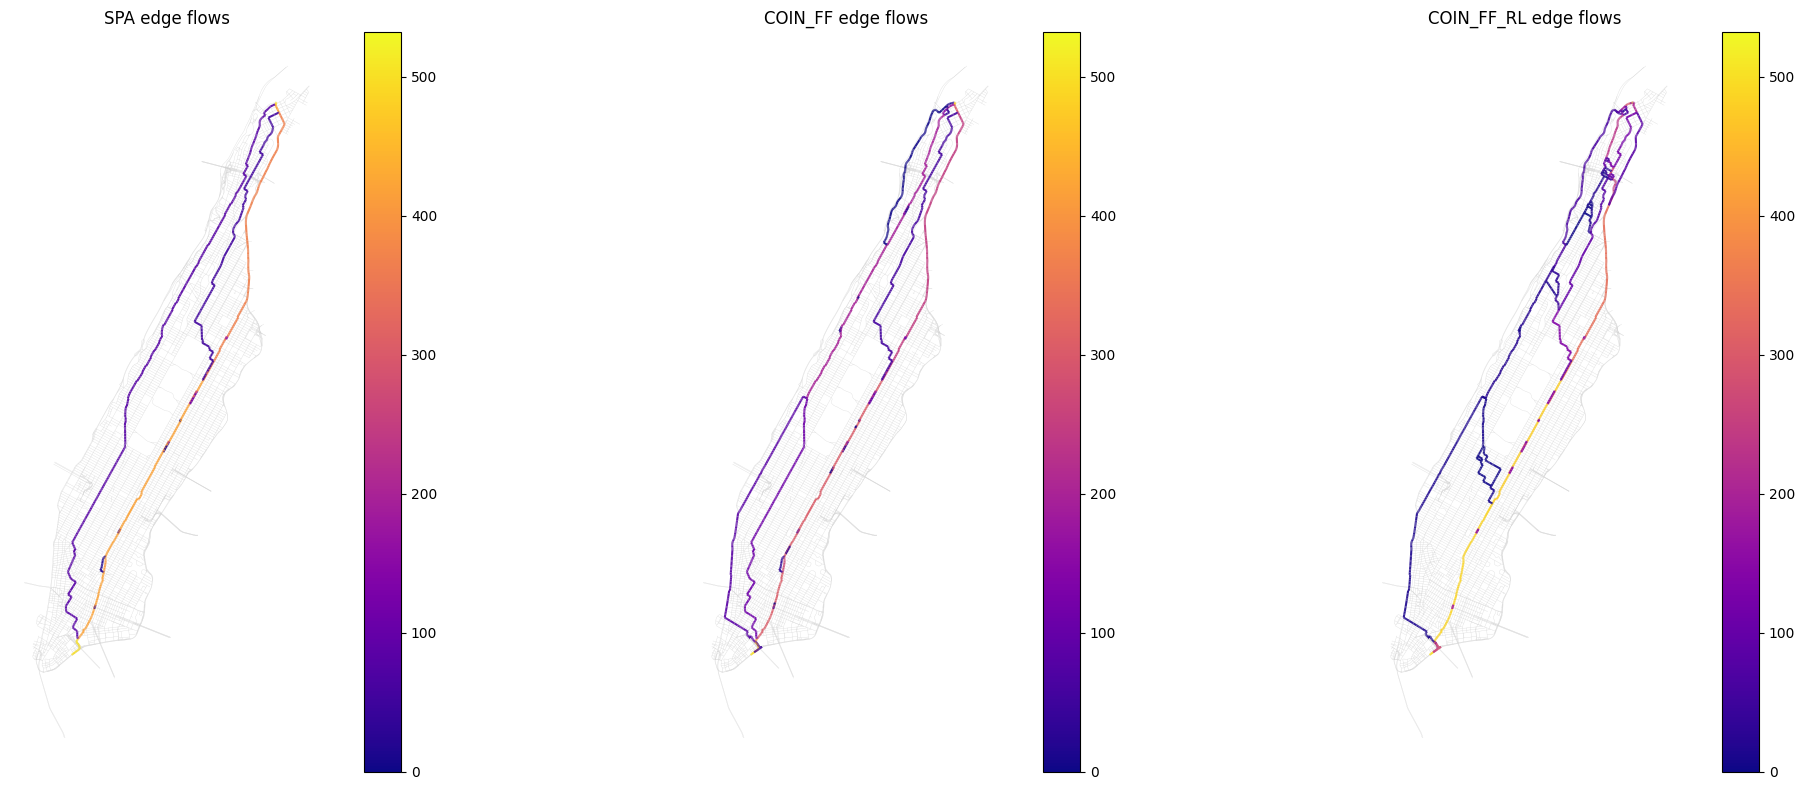

In [75]:
random.seed(42)

# Number of agents:
num_agents = 500

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_rl_from_expert_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents,
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
)

# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa, G_spa,
    agents_coin_ff, G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)

SPA experiment with 1000 agents (fixed O/D)
Total system travel time G_SPA: 6350069.62
Used edges: 4319 / 81228
COIN_FF experiment with 1000 agents (fixed O/D)
Total system travel time G_COIN_FF: 6317565.62
Used edges: 6460 / 81228
Collected 979914 expert (s,d,a,edge_id) steps from 1000 COIN_FF agents.
Trained Q on 979914 expert steps (unique state–action pairs: 6460).

=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC, cost-aware) ===
G_SPA          = 6350069.62
G_COIN_FF      = 6317565.62
G_COIN_FF_RL   = 11608742.94
Improvement (COIN_FF vs SPA)      = 0.51%
Improvement (COIN_FF_RL vs SPA)   = -82.81%

SPA fraction reaching dest: 1.0
COIN_FF fraction reaching dest: 1.0
COIN_FF_RL fraction reaching dest: 1.0

[SPA] metrics:
  Average travel time per agent:  6350.07 s  (105.83 min)
  Total distance traveled:       69640.19 km
  Average distance per agent:       69.64 km

[COIN_FF] metrics:
  Average travel time per agent:  6317.57 s  (105.29 min)
  Total distance traveled:       71598.35 km

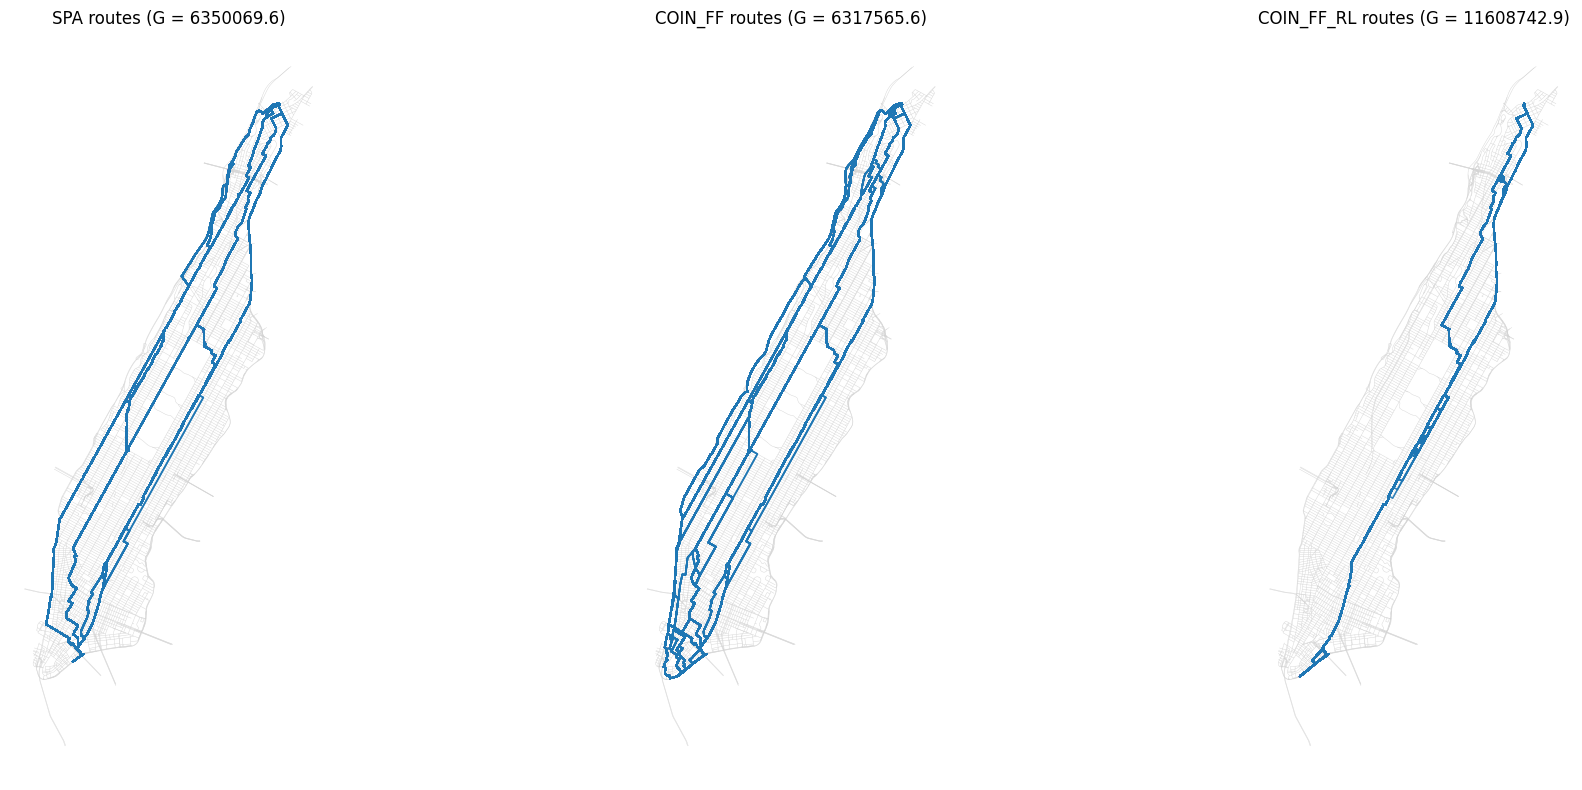

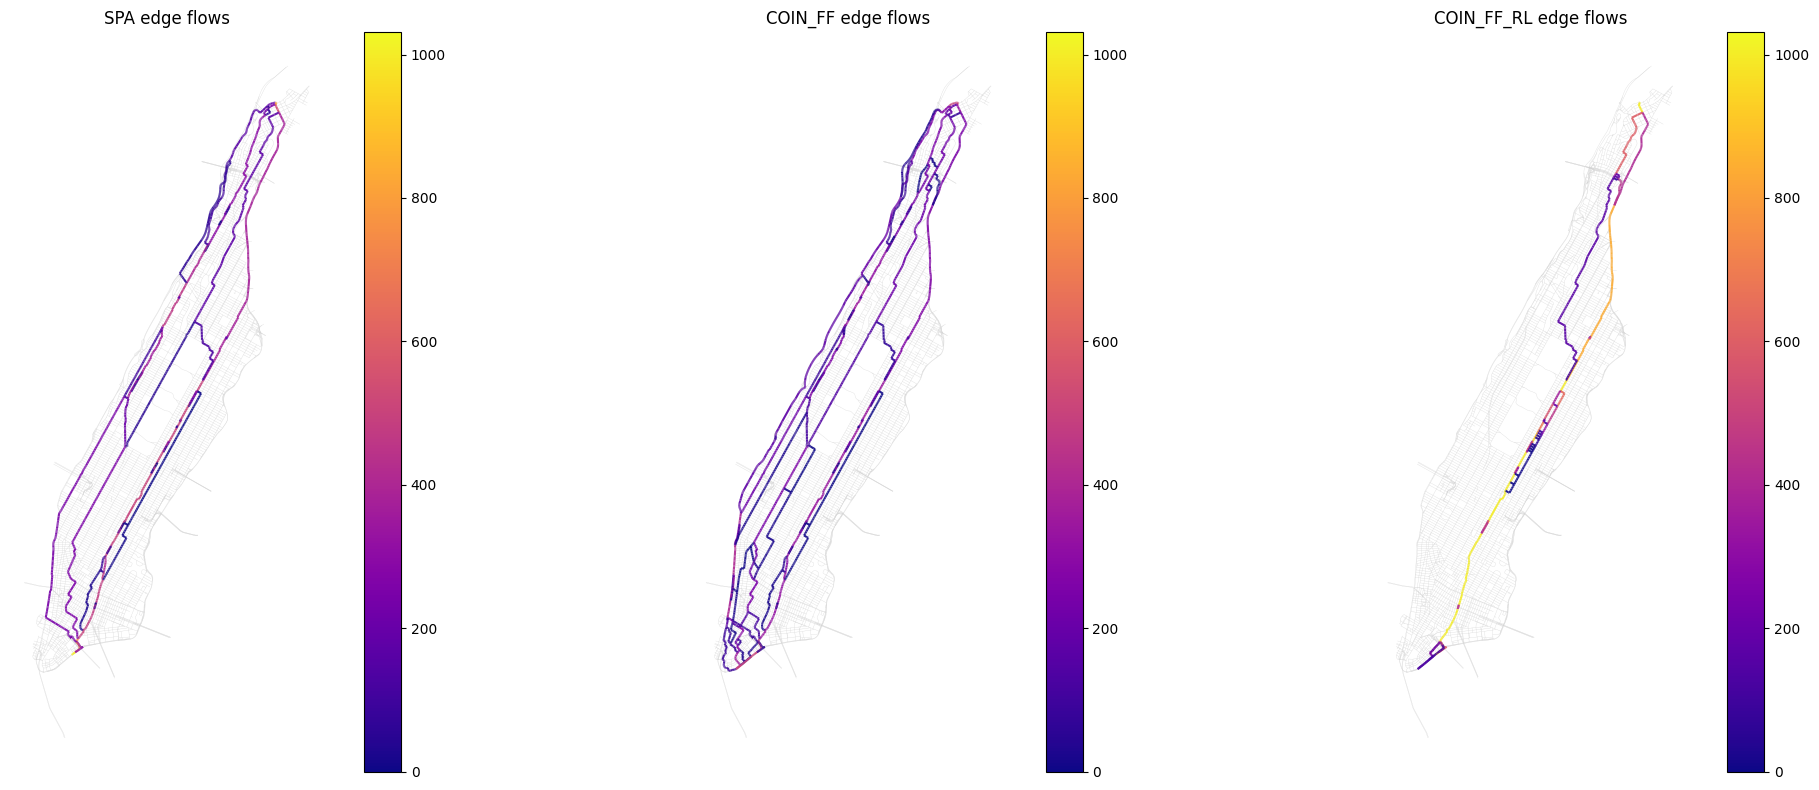

In [76]:
random.seed(42)

# Number of agents:
num_agents = 1000

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_rl_from_expert_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents,
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
)

# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa, G_spa,
    agents_coin_ff, G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)

SPA experiment with 5000 agents (fixed O/D)
Total system travel time G_SPA: 80095853.60
Used edges: 15496 / 81228
COIN_FF experiment with 5000 agents (fixed O/D)
Total system travel time G_COIN_FF: 6317565.62
Used edges: 6460 / 81228
Collected 979914 expert (s,d,a,edge_id) steps from 5000 COIN_FF agents.
Trained Q on 979914 expert steps (unique state–action pairs: 6460).

=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC, cost-aware) ===
G_SPA          = 80095853.60
G_COIN_FF      = 6317565.62
G_COIN_FF_RL   = 16821000261.93
Improvement (COIN_FF vs SPA)      = 92.11%
Improvement (COIN_FF_RL vs SPA)   = -20901.09%

SPA fraction reaching dest: 1.0
COIN_FF fraction reaching dest: 0.2
COIN_FF_RL fraction reaching dest: 1.0

[SPA] metrics:
  Average travel time per agent: 16019.17 s  (266.99 min)
  Total distance traveled:       363778.31 km
  Average distance per agent:       72.76 km

[COIN_FF] metrics:
  Average travel time per agent:  1263.51 s  ( 21.06 min)
  Total distance traveled:       

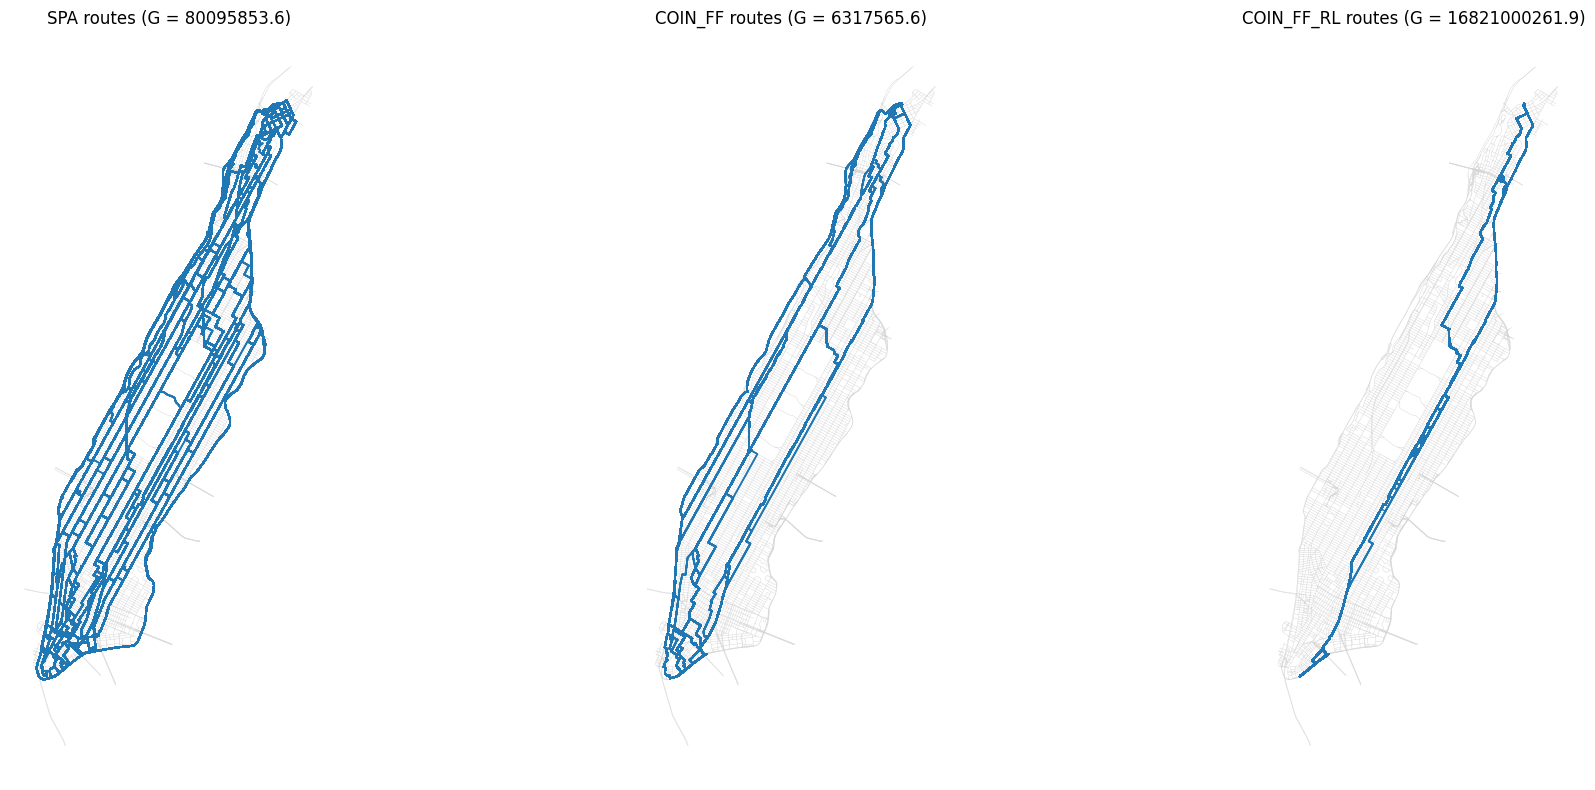

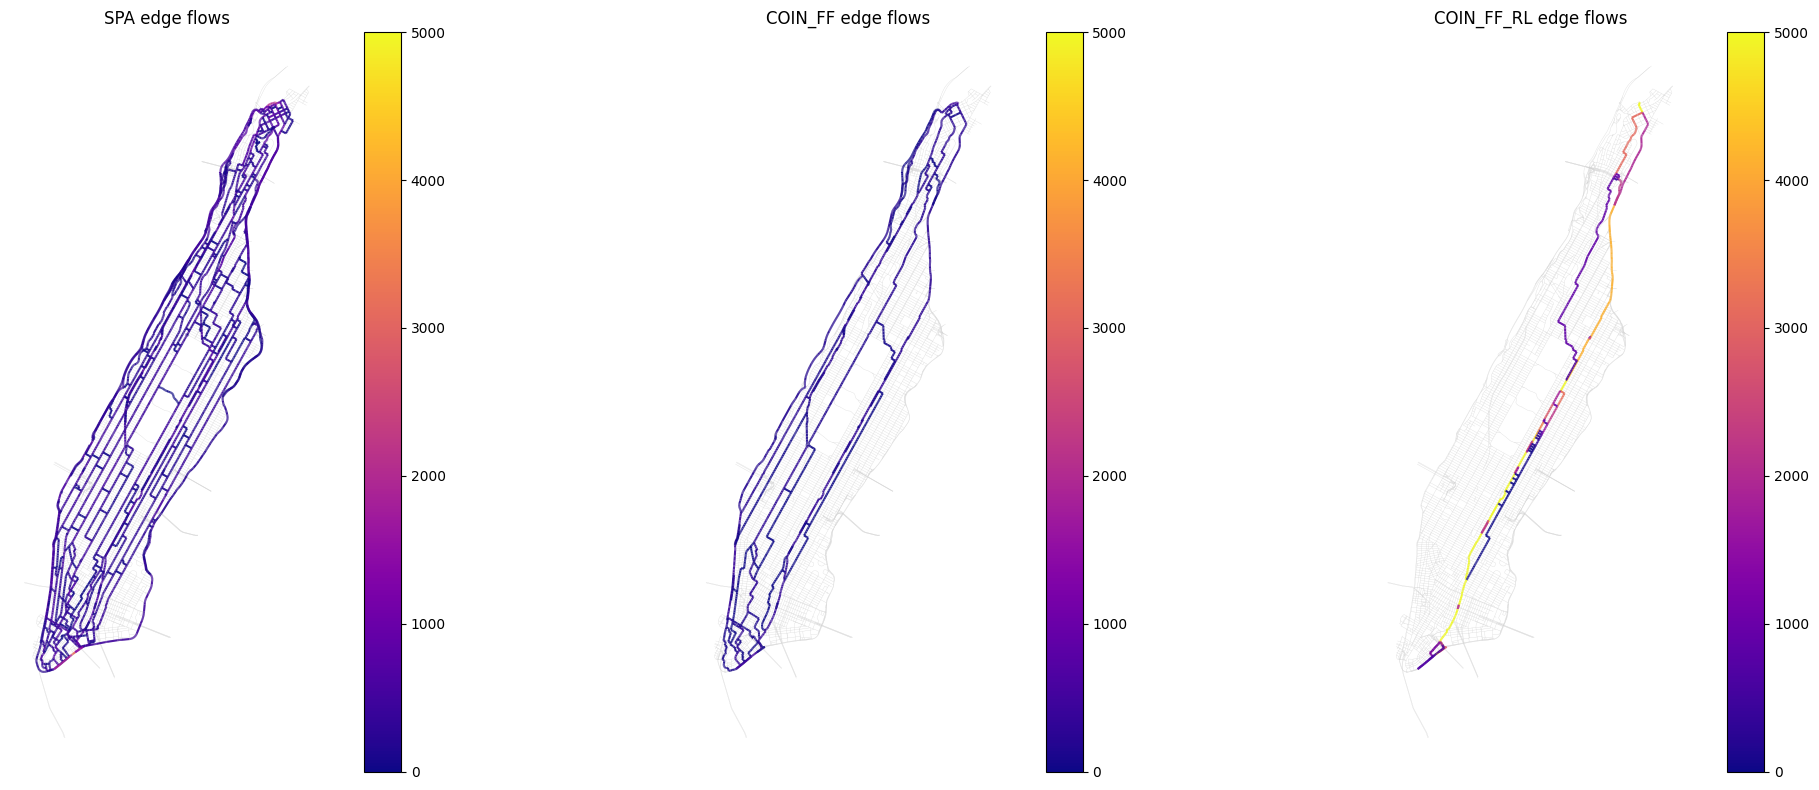

In [78]:
random.seed(42)

# Number of agents:
num_agents = 5000

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_rl_from_expert_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents,
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
)

# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa, G_spa,
    agents_coin_ff, G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)

SPA experiment with 25000 agents (fixed O/D)
Total system travel time G_SPA: 139564758311.64
Used edges: 33662 / 81228
COIN_FF experiment with 25000 agents (fixed O/D)
Total system travel time G_COIN_FF: 6317565.62
Used edges: 6460 / 81228
Collected 979914 expert (s,d,a,edge_id) steps from 25000 COIN_FF agents.
Trained Q on 979914 expert steps (unique state–action pairs: 6460).

=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC, cost-aware) ===
G_SPA          = 139564758311.64
G_COIN_FF      = 6317565.62
G_COIN_FF_RL   = 53006028290056.76
Improvement (COIN_FF vs SPA)      = 100.00%
Improvement (COIN_FF_RL vs SPA)   = -37879.52%

SPA fraction reaching dest: 1.0
COIN_FF fraction reaching dest: 0.04
COIN_FF_RL fraction reaching dest: 1.0

[SPA] metrics:
  Average travel time per agent: 5582590.33 s  (93043.17 min)
  Total distance traveled:       2045318.89 km
  Average distance per agent:       81.81 km

[COIN_FF] metrics:
  Average travel time per agent:   252.70 s  (  4.21 min)
  Total dist

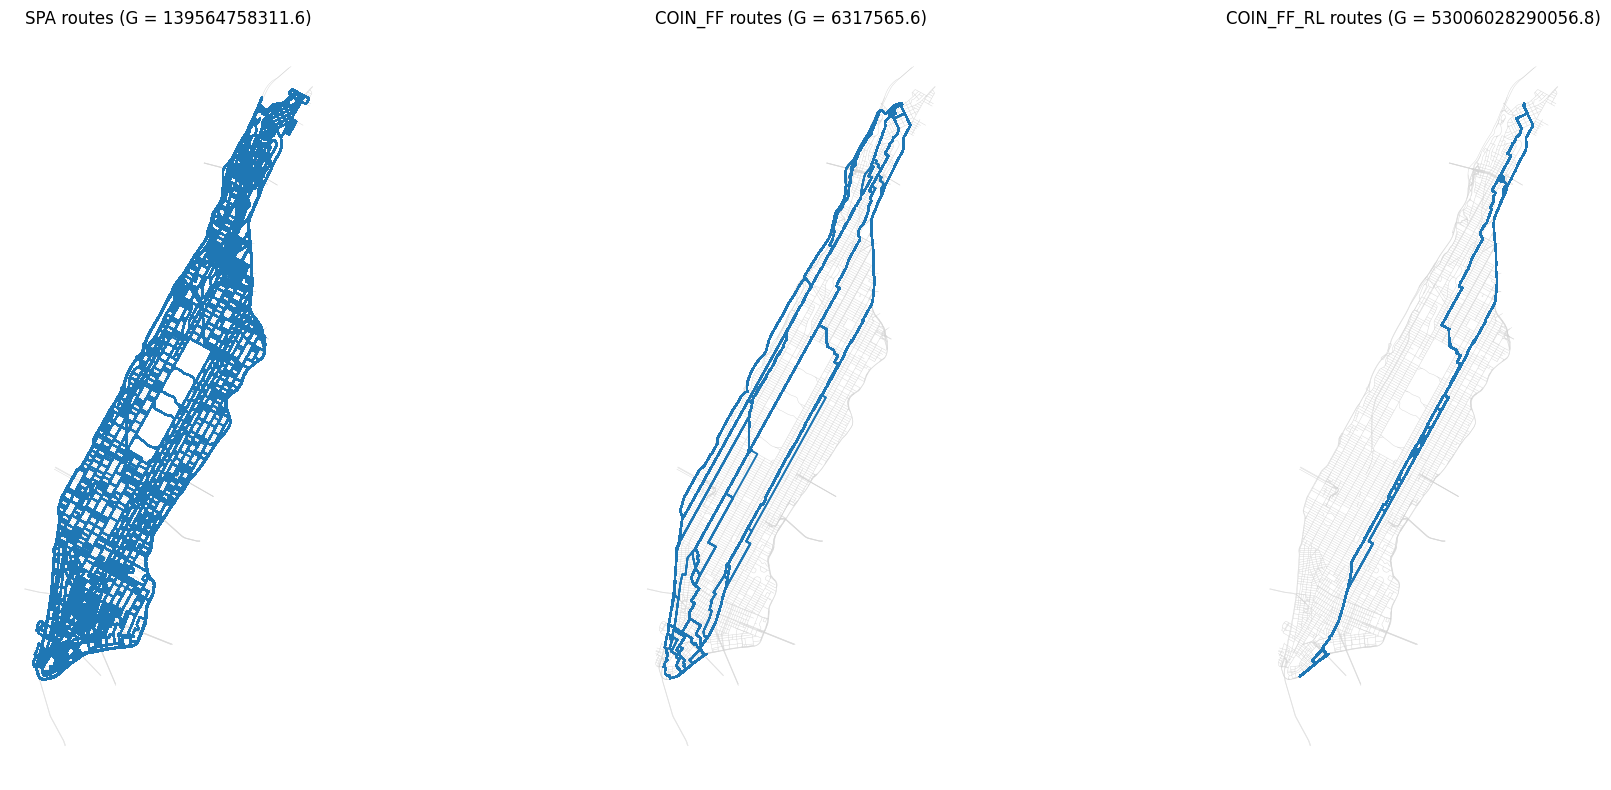

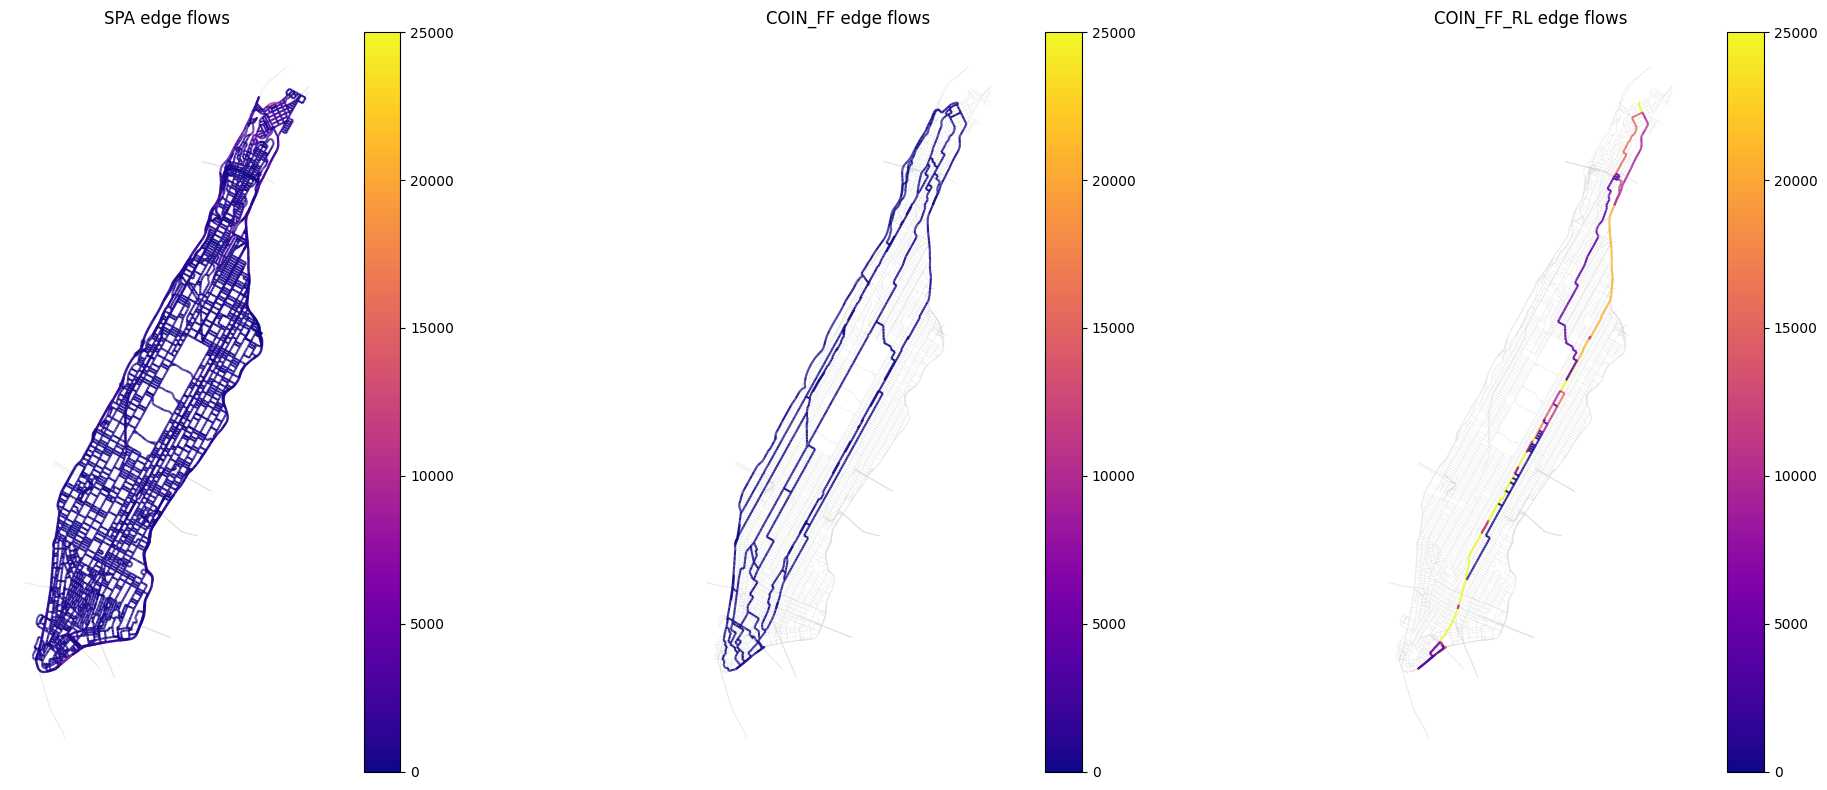

In [79]:
random.seed(42)

# Number of agents:
num_agents = 25000

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_rl_from_expert_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents,
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
)

# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa, G_spa,
    agents_coin_ff, G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)